# LCLS `cu_hxr` Modeling using vanilla Tao

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pytao import Tao
from lcls_live.datamaps.klystron import KlystronDataMap, existing_LCLS_klystrons_sector_station
from lcls_live.datamaps.tabular import TabularDataMap
from lcls_live.tools import isotime
from lcls_live import data_dir
import pandas as pd
import json
import os

In [3]:
# Basic model with options
MODEL = 'cu_hxr'
OPTIONS = f'-slice OTR2:END -noplot'
INIT = f'-init $LCLS_LATTICE/bmad/models/{MODEL}/tao.init {OPTIONS}'

# Make sure this exists
assert 'LCLS_LATTICE' in os.environ

INIT

'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice OTR2:END -noplot'

## Tao

In [4]:
tao = Tao(INIT)

## PVDATA

Load a dict of archived PV data. This is a simple dict of `pvname:value`

In [5]:
PVDATA = json.load(open('data/PVDATA-2021-04-21T08:10:25.000000-07:00.json'))

# DataMaps 

## Quads

In [6]:
def quad_pvinfo(tao, ele):
    """
    Returns dict of PV information for use in a DataMap
    """
    head = tao.ele_head(ele)
    attrs = tao.ele_gen_attribs(ele)
    device = head['alias']
    
    d = {}
    d['bmad_name'] = ele
    d['pvname_rbv'] = device+':BACT'
    d['pvname'] = device+':BDES'    
    d['bmad_factor'] = -1/attrs['L']/10
    d['bmad_attribute'] = 'b1_gradient'
    return d

quad_pvinfo(tao, 'QM01')

{'bmad_name': 'QM01',
 'pvname_rbv': 'QUAD:IN20:631:BACT',
 'pvname': 'QUAD:IN20:631:BDES',
 'bmad_factor': -0.9259259259259259,
 'bmad_attribute': 'b1_gradient'}

In [7]:
quad_names = tao.lat_list('quad::*', 'ele.name', flags='-no_slaves')
quad_s= np.array([tao.ele_head(ele)['s'] for ele in quad_names])

dfq = pd.DataFrame([quad_pvinfo(tao, ele) for ele in quad_names])
dfq

,bmad_name,pvname_rbv,pvname,bmad_factor,bmad_attribute
0,QM01,QUAD:IN20:631:BACT,QUAD:IN20:631:BDES,-0.925926,b1_gradient
1,QM02,QUAD:IN20:651:BACT,QUAD:IN20:651:BDES,-0.925926,b1_gradient
2,QB,QUAD:IN20:731:BACT,QUAD:IN20:731:BDES,-0.936330,b1_gradient
3,QM03,QUAD:IN20:771:BACT,QUAD:IN20:771:BDES,-0.925926,b1_gradient
4,QM04,QUAD:IN20:781:BACT,QUAD:IN20:781:BDES,-0.925926,b1_gradient
...,...,...,...,...,...
179,QHXH46,QUAD:UNDH:4680:BACT,QUAD:UNDH:4680:BDES,-1.190476,b1_gradient
180,QUE1,QUAD:DMPH:300:BACT,QUAD:DMPH:300:BDES,-0.181818,b1_gradient
181,QUE2,QUAD:DMPH:380:BACT,QUAD:DMPH:380:BDES,-0.181818,b1_gradient
182,QDMP1,QUAD:DMPH:500:BACT,QUAD:DMPH:500:BDES,-0.232558,b1_gradient


In [8]:
QUAD_DATAMAP = TabularDataMap(dfq, pvname='pvname', element='bmad_name', attribute = 'bmad_attribute', factor='bmad_factor')
#QUAD_DATAMAP.pvlist

In [9]:
JSONFILE = os.path.join(data_dir, 'cu_hxr/quad_TabularDataMap.json')
QUAD_DATAMAP.to_json(JSONFILE)

## Klystrons

In [10]:
klystron_names = tao.lat_list('overlay::K*', 'ele.name', flags='-no_slaves')

# Export to file and reload
klystron_datamaps = []
for i, identifier in enumerate(existing_LCLS_klystrons_sector_station):
    sector = identifier[0]
    station = identifier[1]
    
    JSONFILE = os.path.join(data_dir, f'cu_hxr/sector{sector}_station{station}_klystron_datamap.json')
    klystron_datamaps.append(KlystronDataMap.from_json(JSONFILE))


# Just take the ones that we have
klystron_datamaps = [k for k in klystron_datamaps if k.name in klystron_names]

## Linac and Bunch Compressors

In [11]:
LINAC_JSON = os.path.join(data_dir, 'cu_hxr/linac_TabularDataMap.json')
LINAC_DATAMAP = TabularDataMap.from_json(LINAC_JSON)
LINAC_DATAMAP.data

,name,pvname,bmad_factor,bmad_name,bmad_attribute,description,bmad_offset
0,BC1_offset,BMLN:LI21:235:MOTR,0.001,O_BC1_OFFSET,offset,None,NaN
1,BC2_offset,BMLN:LI24:805:MOTR,0.001,O_BC2_OFFSET,offset,None,NaN
2,L1_phase,ACCL:LI21:1:L1S_S_PV,0.000,O_L1,phase_deg,"Controls the L1 phase, which is the single kly...",NaN
3,L2_phase,ACCL:LI22:1:PDES,1.000,O_L2,phase_deg,None,NaN
4,L3_phase,ACCL:LI25:1:PDES,NaN,O_L3,phase_deg,None,0.0


## Energy measurements

In [12]:
ENERGY_MEAS = os.path.join(data_dir, 'cu_hxr/tao_energy_measurements_TabularDataMap.json')
ENERGY_MEAS_DATAMAP = TabularDataMap.from_json(open(ENERGY_MEAS).read())
ENERGY_MEAS_DATAMAP.data

,name,pvname,tao_datum,factor
0,L1_energy,BEND:LI21:231:EDES,BC1.energy[1],1000000000
1,L2_energy,BEND:LI24:790:EDES,BC2.energy[1],1000000000
2,L3_HXR_energy,BEND:DMPH:400:EDES,L3.energy[2],1000000000


## Subboosters

In [13]:
SUBBOSTER_DATAMAP = TabularDataMap.from_json(os.path.join(data_dir, 'cu/subboosters_TabularDataMap.json'))
SUBBOSTER_DATAMAP.data

,name,phase_pvname,desciption,bmad_name,bmad_attribute
0,SBST_21,SBST:LI21:1:PHAS,Normal subbooster,SBST_21,phase_deg
1,SBST_22,SBST:LI22:1:PHAS,Normal subbooster,SBST_22,phase_deg
2,SBST_23,SBST:LI23:1:PHAS,Normal subbooster,SBST_23,phase_deg
3,SBST_24,SBST:LI24:1:PHAS,Normal subbooster,SBST_24,phase_deg
4,SBST_25,SBST:LI25:1:PHAS,Normal subbooster,SBST_25,phase_deg
5,SBST_26,SBST:LI26:1:PHAS,Normal subbooster,SBST_26,phase_deg
6,SBST_27,SBST:LI27:1:PHAS,Normal subbooster,SBST_27,phase_deg
7,SBST_28,SBST:LI28:1:PHAS,Normal subbooster,SBST_28,phase_deg
8,SBST_29,ACCL:LI29:0:KLY_PDES,Special feedback subbooster,SBST_29,phase_deg
9,SBST_30,ACCL:LI30:0:KLY_PDES,Special feedback subbooster,SBST_30,phase_deg


## Beginning Twiss parameters

In [14]:
BEGINNING_TWISS_DATAMAP = TabularDataMap.from_json(os.path.join(data_dir, 'cu/beginning_WS02_TabularDataMap.json'))
BEGINNING_TWISS_DATAMAP.data

,name,pvname,bmad_name,bmad_attribute
0,WS02_beta_x_meas,WIRE:IN20:561:BETA_X,beginning,beta_a
1,WS02_beta_y_meas,WIRE:IN20:561:BETA_Y,beginning,beta_b
2,WS02_alpha_x_meas,WIRE:IN20:561:ALPHA_X,beginning,alpha_a
3,WS02_alpha_y_meas,WIRE:IN20:561:ALPHA_Y,beginning,alpha_b


## Collect all DataMaps

In [15]:
ALL_DATAMAPS = klystron_datamaps + [QUAD_DATAMAP, LINAC_DATAMAP, ENERGY_MEAS_DATAMAP, SUBBOSTER_DATAMAP, BEGINNING_TWISS_DATAMAP]

#ALL_DATAMAPS = [QUAD_DATAMAP]

def get_pvlist():
    pvlist = set()
    for dm in ALL_DATAMAPS:
        for pv in dm.pvlist:
            pvlist.add(pv) 
    return list(pvlist)

def get_bmad(pvdata):
    lines = []
    for dm in ALL_DATAMAPS:
        lines += dm.as_bmad(pvdata)
    return lines

def get_tao(pvdata):
    lines = []
    for dm in ALL_DATAMAPS:
        lines += dm.as_tao(pvdata)
    return lines

# Get a list of all PVs needed
ALL_PVS = get_pvlist()
len(ALL_PVS)

741

# Prepare all commands

In [16]:
tao = Tao('-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice WS02:END -noplot')

In [17]:
%%time
init_cmds = """
place floor energy
!set global plot_on = F
set global lattice_calc_on = F
set lattice model=design ! Reset the lattice
set ele quad::* field_master = T
""".split('\n')

cmds = get_tao(PVDATA)

final_cmds = """
set global lattice_calc_on = T
!set global plot_on = T
""".split('\n')

all_cmds = init_cmds + cmds + final_cmds

for cmd in all_cmds:
    tao.cmd(cmd)

CPU times: user 132 ms, sys: 14.6 ms, total: 146 ms
Wall time: 148 ms


In [18]:
# Output collecting

outkeys = """ele.name
ele.ix_ele
ele.ix_branch
ele.a.beta
ele.a.alpha
ele.a.eta
ele.a.etap
ele.a.gamma
ele.a.phi
ele.b.beta
ele.b.alpha
ele.b.eta
ele.b.etap
ele.b.gamma
ele.b.phi
ele.x.eta
ele.x.etap
ele.y.eta
ele.y.etap
ele.s
ele.l
ele.e_tot
ele.p0c
ele.mat6
ele.vec0
""".split()
def get_output(tao):
    return {k:tao.lat_list('*', k) for k in outkeys}

In [19]:
def evaluate_tao(tao, cmds):

    # Init
    for cmd in init_cmds:
        tao.cmd(cmd)

    for cmd in cmds:
        tao.cmd(cmd)
    
    # Turn lattice calc on
    for cmd in final_cmds:
        tao.cmd(cmd)    
        
    output = get_output(tao)
    
    return output

In [20]:
O = evaluate_tao(tao, cmds)
O.keys()

dict_keys(['ele.name', 'ele.ix_ele', 'ele.ix_branch', 'ele.a.beta', 'ele.a.alpha', 'ele.a.eta', 'ele.a.etap', 'ele.a.gamma', 'ele.a.phi', 'ele.b.beta', 'ele.b.alpha', 'ele.b.eta', 'ele.b.etap', 'ele.b.gamma', 'ele.b.phi', 'ele.x.eta', 'ele.x.etap', 'ele.y.eta', 'ele.y.etap', 'ele.s', 'ele.l', 'ele.e_tot', 'ele.p0c', 'ele.mat6', 'ele.vec0'])

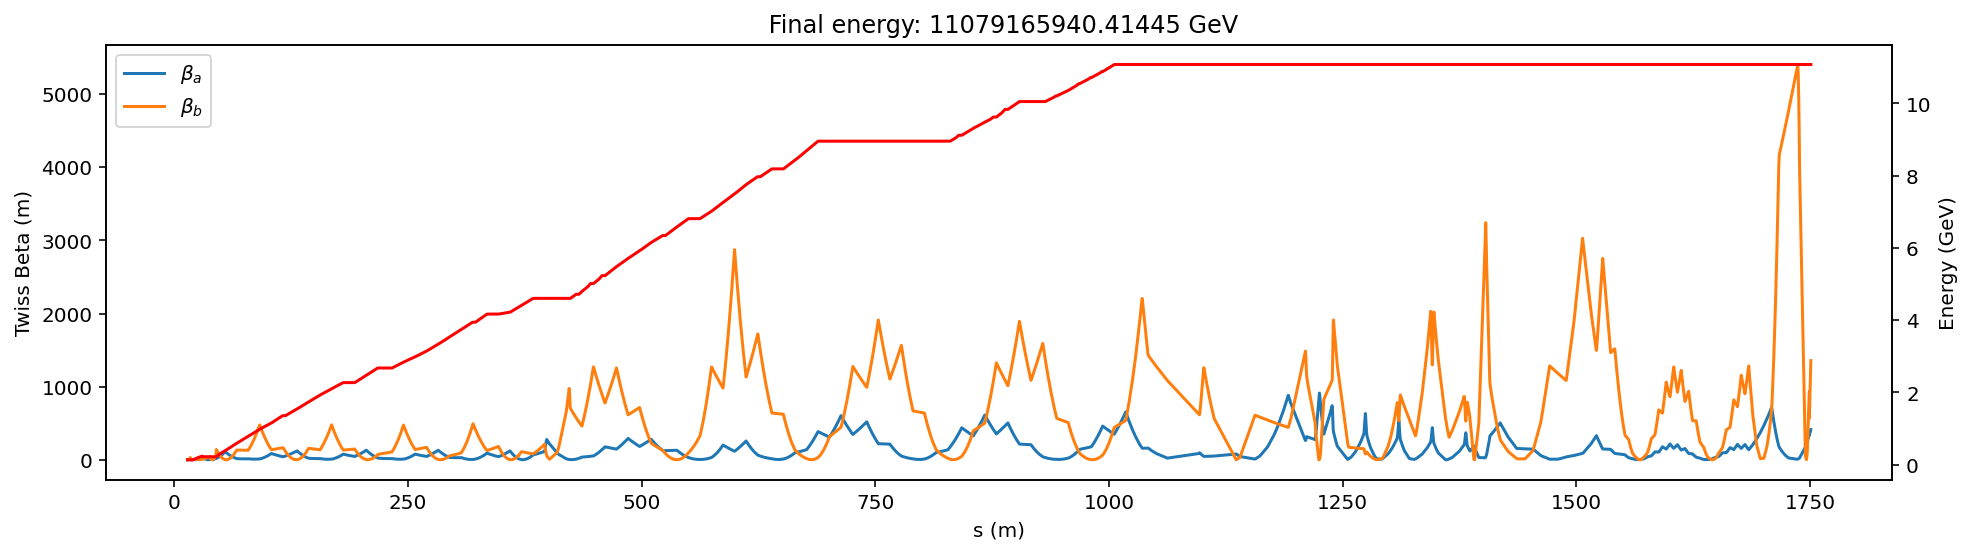

In [21]:
def plot_twiss(output, info=''):
    fig, ax = plt.subplots(figsize=(16,4))
    
    ax.plot(output['ele.s'], output['ele.a.beta'], label = r'$\beta_a$')
    ax.plot(output['ele.s'], output['ele.b.beta'], label = r'$\beta_b$')
    plt.legend()
    
    # Add energy to the rhs
    ax2 = ax.twinx()
    ax2.plot(output['ele.s'], output['ele.e_tot']/1e9, color='red')
    ax2.set_ylabel('Energy (GeV)')
    
    ax.set_xlabel('s (m)')
    ax.set_ylabel('Twiss Beta (m)')
    
    itime = isotime()
    efinal = output['ele.e_tot'][-1]
    plt.title(f'{info} Final energy: {efinal} GeV')
        
    return fig

plot_twiss(O);   

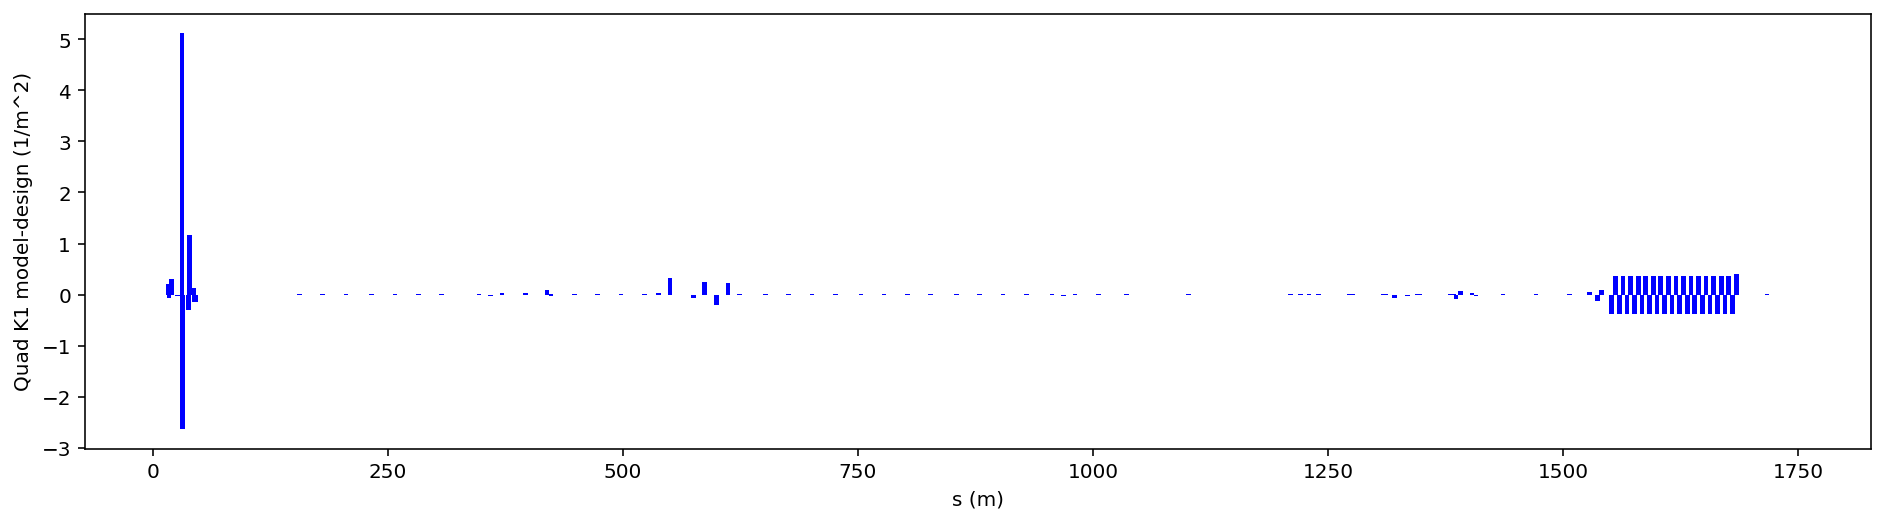

In [22]:
def plot_quad_k1():
    fig, ax = plt.subplots(figsize=(16,4))
    quad_k1_model = np.array([tao.ele_gen_attribs(ele, which='model')['K1'] for ele in quad_names])
    quad_k1_design = np.array([tao.ele_gen_attribs(ele, which='design')['K1'] for ele in quad_names])
    ax.bar(quad_s, quad_k1_model - quad_k1_design, color='blue', width=5)
    ax.set_xlabel('s (m)')
    ax.set_ylabel('Quad K1 model-design (1/m^2)')
plot_quad_k1()    

# Restore from the Archiver

In [23]:
from lcls_live.archiver import lcls_archiver_restore
import os 
# Open an SSH tunnel in a terminal like:
# ssh -D 8080 cmayes@rhel6-64.slac.stanford.edu 
# And then set:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

In [24]:
# Pick a proper time
ISOTIME = '2021-04-21T08:10:25.000000-07:00'
#ISOTIME = '2021-01-20T01:10:43.000000-07:00'
ARCHIVED_PVDATA = lcls_archiver_restore(ALL_PVS, ISOTIME)

# Save for restoring later
AOUT = f'data/PVDATA-{ISOTIME}.json'
json.dump(ARCHIVED_PVDATA, open(AOUT, 'w'))

# Some of the commands
cmds = get_tao(ARCHIVED_PVDATA)
cmds[0:10]

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2021-04-21T08:10:25.000000-07:00&includeProxies=true


['set ele K21_1 ENLD_MeV = 110.97650650294992',
 'set ele K21_1 phase_deg = -22.43420088792822',
 'set ele K21_1 in_use = 1',
 'set ele K21_2 ENLD_MeV = 17.765575680624593',
 'set ele K21_2 phase_deg = -160.19061303694605',
 'set ele K21_2 in_use = 1',
 'set ele K21_3 ENLD_MeV = 205.449',
 'set ele K21_3 phase_deg = -0.14282989501953125',
 'set ele K21_3 in_use = 1',
 'set ele K21_4 ENLD_MeV = 257.928']

In [25]:
fout = 'test.tao'
all_cmds = init_cmds + cmds + final_cmds
with open(fout, 'w') as f:
    for line in all_cmds:
        f.write(line+'\n')
os.path.abspath(fout)

'/Users/chrisonian/Code/GitHub/lcls-live/examples/test.tao'

In [26]:
%%time
OUT = evaluate_tao(tao, cmds)

CPU times: user 152 ms, sys: 20.3 ms, total: 173 ms
Wall time: 174 ms


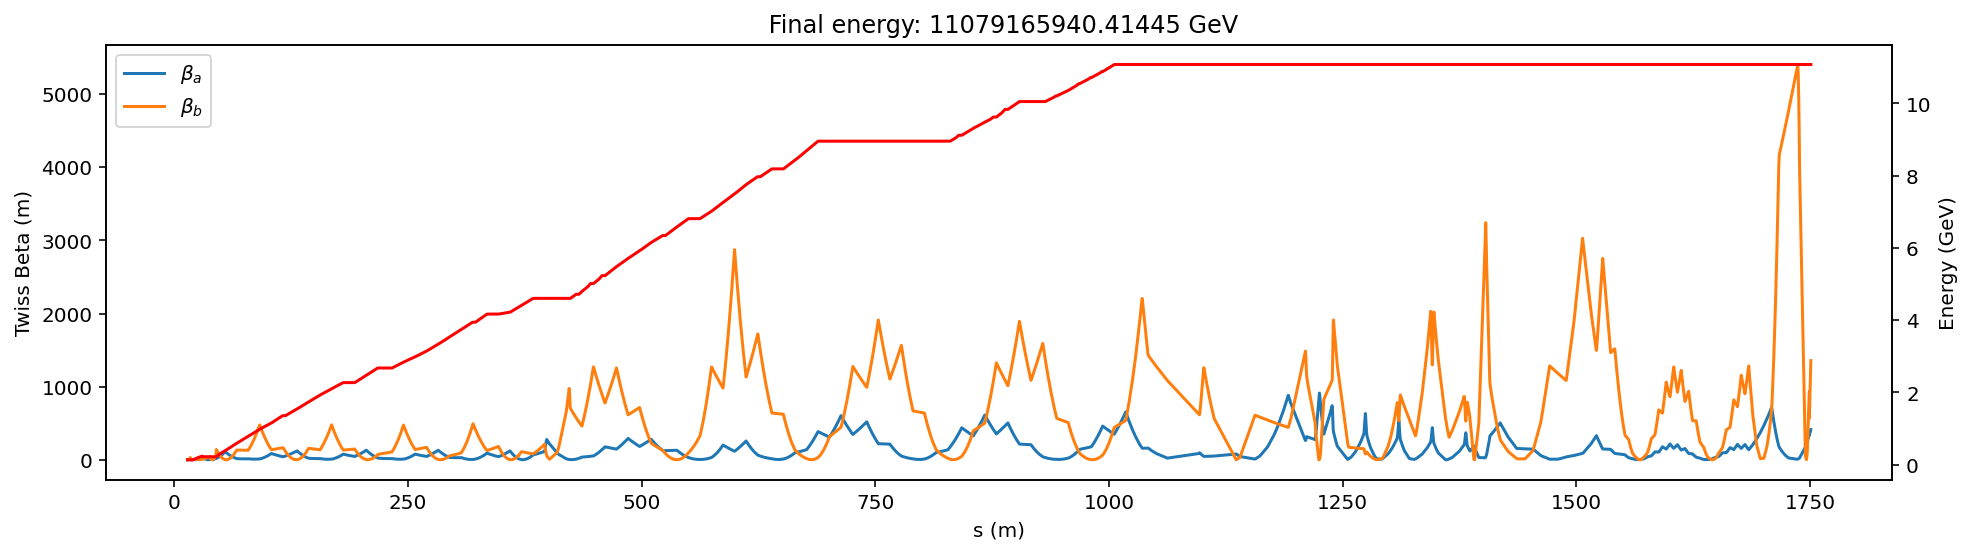

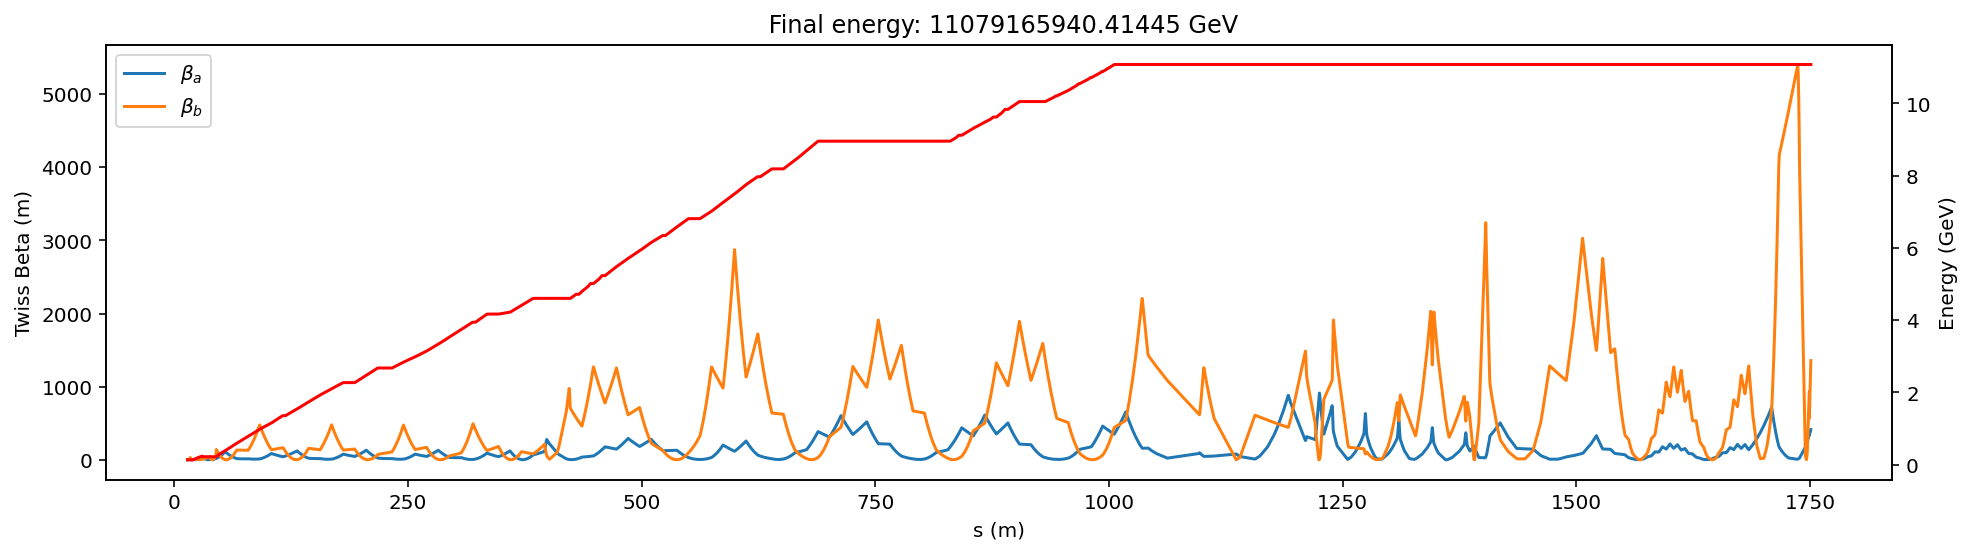

In [27]:
plot_twiss(OUT)  

# Live loop

In [28]:
import epics

def get_live():
    pvlist = get_pvlist()
    return dict(zip(pvlist, epics.caget_many(pvlist)))

In [29]:
init_cmds = """
!place floor energy
!place top beta
!place middle eta
!place bottom layout 
!x-a all s
!sc
!set global plot_on = F
set global lattice_calc_on = F
set lattice model=design ! Reset the lattice
!set ele quad::* field_master = T
""".split('\n')

final_cmds = """
set global lattice_calc_on = T
!set global plot_on = T
!sc
""".split('\n')

In [30]:
%%time
pvdata = get_live()
cmds = get_tao(pvdata)
output = evaluate_tao(tao, cmds)

CPU times: user 1.34 s, sys: 179 ms, total: 1.52 s
Wall time: 1.76 s


In [31]:
from IPython.display import clear_output

In [32]:
def plot1():
    """
    Get live EPICS data and plot
    """
    pvdata = get_live()
    cmds = get_tao(pvdata)
    output = evaluate_tao(tao, cmds)    
    
    clear_output(wait=True)  
    fig = plot_twiss(output, info=isotime())  

    fig.axes[0].set_ylim(0,5000)
    

    plt.show()
    

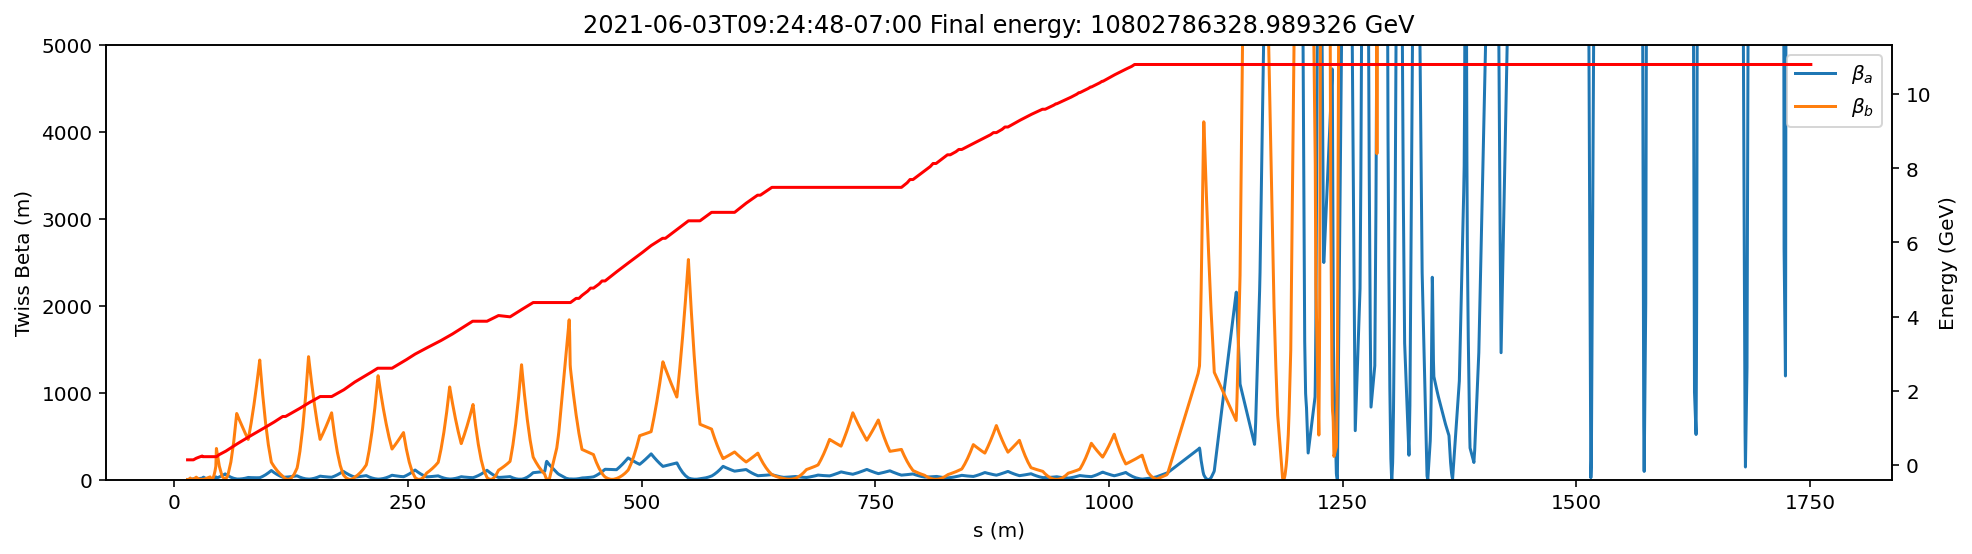

CPU times: user 1.55 s, sys: 165 ms, total: 1.71 s
Wall time: 1.91 s


In [33]:
%%time
plot1()

In [ ]:
# Run forever
while True:
    plot1()

# Command line tool

For convenience a stand-alone command line tool can get Tao commands from EPICS or the archiver

In [ ]:
!get-lcls-live 

In [ ]:
!get-lcls-live --beampath cu_sxr --source epics --tao |head

In [37]:
# This can also be used in code
from lcls_live.command_line import get_cmds
?get_cmds

Signature: get_cmds(source: str, beampath: str, cmd_type: str, isotime: str = None)
Docstring:
Function for generating commands.

Args:
    source (str): archiver or epics
    beampath (str): Model beampath
    isotime (str): Isotime stringpath
    cmd_type (str): tao or bmad
File:      ~/Code/GitHub/lcls-live/lcls_live/command_line.py
Type:      function


In [ ]:
cmds = get_cmds(source='epics', beampath='cu_sxr', cmd_type='tao')

# Be sure to turn the lattice calc off if changing many things
cmds.insert(0, 'set global lattice_calc_on = F')
cmds.append('set global lattice_calc_on = T')

In [ ]:
# Apply the commands
tao = Tao('-init $LCLS_LATTICE/bmad/models/cu_sxr/tao.init -slice WS02:END -noplot')
for cmd in cmds:
    tao.cmd(cmd)

In [ ]:
output = get_output(tao)
plot_twiss(output, info=isotime());